### The STV-FIS effort is funded by the NASA Decadal Survey Incubation program - **NNH21ZDA001N-DSI**

# SDAP Tomogram & LIDAR Subsetting & Visualization Endpoints

This notebook showcases some work in progress vizualization capabilities built directly into SDAP for the purposes of visuzlizing SAR and LIDAR data. The following demo products were used:
- SAR: Work in progress geolocated product (not publicly availabe). Kings Canyon, CA; Lope Nat'l Park, Gabon (HH, HV, VV); Rabi Forest, Gabon (HH, HV, VV); Redwood Nat'l Park, CA (HH, HV, VV | L- & P-band)
- LIDAR: [This dataset](https://daac.ornl.gov/ABOVE/guides/ABoVE_LVIS_VegetationStructure.html) (ABoVE: LVIS L3 Gridded Vegetation Structure across North America, 2017 and 2019)
- Kauri: An ML fusion product using SAR and LIDAR data to predict RH98 (canopy height).

LIDAR support is commented out (as of 2024-04-11) as the version of SDAP currently deployed does not support LIDAR, nor is it ingested into said deployment.

**NOTE**

You must be connected to the JPL Network/VPN to run this notebook. 

In [1]:
from datetime import datetime
from io import BytesIO, StringIO
from math import floor, ceil
from zipfile import ZipFile

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import urllib3
import xarray as xr
from IPython.display import display
from PIL import Image

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# NOTE: Disabling verification due to certificate issues on my local machine

def get(url, params):
    t = datetime.now()
    
    try:
        print('Waiting for response from SDAP...', end='')
        response = requests.get(url, params=params, verify=False)
        td = datetime.now() - t
        response.raise_for_status()
        
        print(f' Done in {td}')
    except:
        td = datetime.now() - t
        print(f' Failed in {td}')
        print(response.text)
        raise
        
    return response

In [2]:
BASE_URL = 'https://digitaltwin.jpl.nasa.gov'
NEXUS_URL = f'{BASE_URL}/nexus'

# TOMOGRAM_ELEV_URL = f'{NEXUS_URL}/tomogram/elevation'
TOMOGRAM_LAT_URL = f'{NEXUS_URL}/tomogram/latitude'
TOMOGRAM_LON_URL = f'{NEXUS_URL}/tomogram/longitude'
TOMOGRAM_3D_URL = f'{NEXUS_URL}/tomogram/3d'

LIDAR_URL = f'{NEXUS_URL}/stv/lidar'

TOMOGRAM_DS_KC = 'Kings_Canyon_Tomogram'
TOMOGRAM_DS_Lope = 'Lope_Tomogram_{}'
TOMOGRAM_DS_Rabi = 'Rabi_Tomogram_{}'
TOMOGRAM_DS_Redwood_Lband = 'Redwood_Tomogram_L_{}'
TOMOGRAM_DS_Redwood_Pband = 'Redwood_Tomogram_P_{}'
LIDAR_DS = 'LVIS_ABoVE'

## Tomograms

### Tomogram Profile Plots

In [ ]:
sites = [
    ('Kings Canyon National Park, US', 'kcnp'),
    ('Lope National Park, GA', 'lope'),
    ('Rabi Forest, GA', 'rabi'),
    ('Redwood National Park, US (L-band)', 'redl'),
    ('Redwood National Park, US (P-band)', 'redp'),
]

site_sel = widgets.Dropdown(options=sites, description='Site: ', disabled=False, layout = widgets.Layout(width='350px'))
pol_sel = widgets.Dropdown(options=['HH', 'HV', 'VV'], description='Pol: ', disabled=False, layout = widgets.Layout(width='350px'))
dim_sel = widgets.Dropdown(options=['Latitude', 'Longitude'], description='Direction: ', disabled=False, layout = widgets.Layout(width='350px'))
dem_sel = widgets.Checkbox(value=True, disabled=False, description='Add DEM')
peaks = widgets.Checkbox(value=False, disabled=False, description='Show peaks in plot')


display(site_sel)
display(pol_sel)
display(dim_sel)
display(dem_sel)
display(peaks)

In [ ]:
PARAMS = {
    'kcnp': dict(ds=TOMOGRAM_DS_KC,            bounds=dict(min_lon=-119.60,  max_lon=-118.75,  min_lat=36.98,  max_lat=37.15,  min_elev=66.84,  max_elev=3732.20, min_elev_nd=-60,  max_elev_nd=60), stride=1, elevationMargin=0.5),
    'lope': dict(ds=TOMOGRAM_DS_Lope,          bounds=dict(min_lon=11.43,    max_lon=11.83,    min_lat=-0.34,  max_lat=0.07,   min_elev=2.5,    max_elev=717.87,  min_elev_nd=-102, max_elev_nd=56), stride=2, elevationMargin=1),
    'rabi': dict(ds=TOMOGRAM_DS_Rabi,          bounds=dict(min_lon=9.70,     max_lon=10.11,    min_lat=-2.05,  max_lat=-1.65,  min_elev=-94.90, max_elev=236.65,  min_elev_nd=-102, max_elev_nd=56), stride=2, elevationMargin=1),
    'redl': dict(ds=TOMOGRAM_DS_Redwood_Lband, bounds=dict(min_lon=-124.247, max_lon=-123.903, min_lat=41.571, max_lat=41.888, min_elev=-89.13, max_elev=1147.06, min_elev_nd=-60,  max_elev_nd=60), stride=1, elevationMargin=0.5),
    'redp': dict(ds=TOMOGRAM_DS_Redwood_Pband, bounds=dict(min_lon=-124.247, max_lon=-123.896, min_lat=41.528, max_lat=41.888, min_elev=-89.22, max_elev=1146.80, min_elev_nd=-60,  max_elev_nd=60), stride=1, elevationMargin=0.5),
}

params = PARAMS[site_sel.value]

if site_sel.value != 'kcnp':
    params['ds'] = params['ds'].format(pol_sel.value)
    
if not dem_sel.value:
    params['ds'] = params['ds'] + '_NO_DEM'
    params['bounds']['min_elev'] = params['bounds']['min_elev_nd']
    params['bounds']['max_elev'] = params['bounds']['max_elev_nd']

del params['bounds']['min_elev_nd']
del params['bounds']['max_elev_nd']

s = widgets.FloatSlider(
    value=((params['bounds']['min_lon'] + params['bounds']['max_lon']) / 2) if dim_sel.value == 'Longitude' else ((params['bounds']['min_lat'] + params['bounds']['max_lat']) / 2),
    min=params['bounds']['min_lon'] if dim_sel.value == 'Longitude' else params['bounds']['min_lat'],
    max=params['bounds']['max_lon'] if dim_sel.value == 'Longitude' else params['bounds']['max_lat'],
    step=0.001,
    description=f'{dim_sel.value}: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
    layout = widgets.Layout(width='500px')
)

d = widgets.FloatRangeSlider(
    value=[
        params['bounds']['min_lat'] if dim_sel.value == 'Longitude' else params['bounds']['min_lon'],
        params['bounds']['max_lat'] if dim_sel.value == 'Longitude' else params['bounds']['max_lon']
    ],
    min=params['bounds']['min_lat'] if dim_sel.value == 'Longitude' else params['bounds']['min_lon'],
    max=params['bounds']['max_lat'] if dim_sel.value == 'Longitude' else params['bounds']['max_lon'],
    step=0.01,
    description='Latitude: ' if dim_sel.value == 'Longitude' else 'Longitude: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout = widgets.Layout(width='500px')
)

e = widgets.IntRangeSlider(
    value=[params['bounds']['min_elev'], params['bounds']['max_elev']],
    min=floor(params['bounds']['min_elev']),
    max=ceil(params['bounds']['max_elev']),
    step=1,
    description='Elevation: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout = widgets.Layout(width='500px')
)

display(s)
display(d)
display(e)

In [ ]:
if dim_sel.value == 'Longitude':
    params['longitude'] = s.value
    (params['minLat'], params['maxLat']) = d.value
    url = TOMOGRAM_LON_URL
else:
    params['latitude'] = s.value
    (params['minLon'], params['maxLon']) = d.value
    url = TOMOGRAM_LAT_URL
    
(params['minElevation'], params['maxElevation']) = e.value
params['output'] = 'PNG'
params['peaks'] = peaks.value

response = get(url, {p: params[p] for p in params if p != 'bounds'})

buf = BytesIO(response.content)

img = Image.open(buf).convert('RGB')
display(img)

## Tomogram Profile Plots - Fixed Examples

Waiting for response from SDAP... Done in 0:00:16.102719


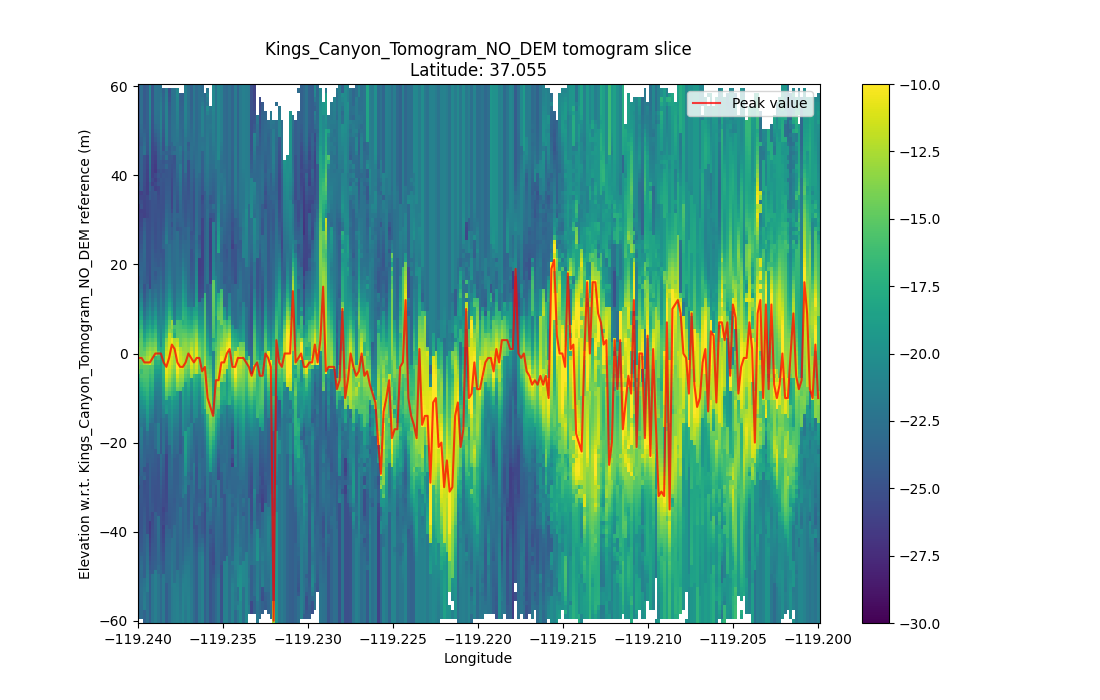

In [3]:
params = dict(
    ds=TOMOGRAM_DS_KC + '_NO_DEM',
    output='PNG',
    latitude=37.055,
    minLon=-119.24,
    maxLon=-119.2,
    minElevation=-121,
    maxElevation=121,
    stride=1,
    peaks=True
)

response = get(TOMOGRAM_LAT_URL, params)

buf = BytesIO(response.content)

img = Image.open(buf).convert('RGB')
display(img)

Waiting for response from SDAP... Done in 0:00:27.402961


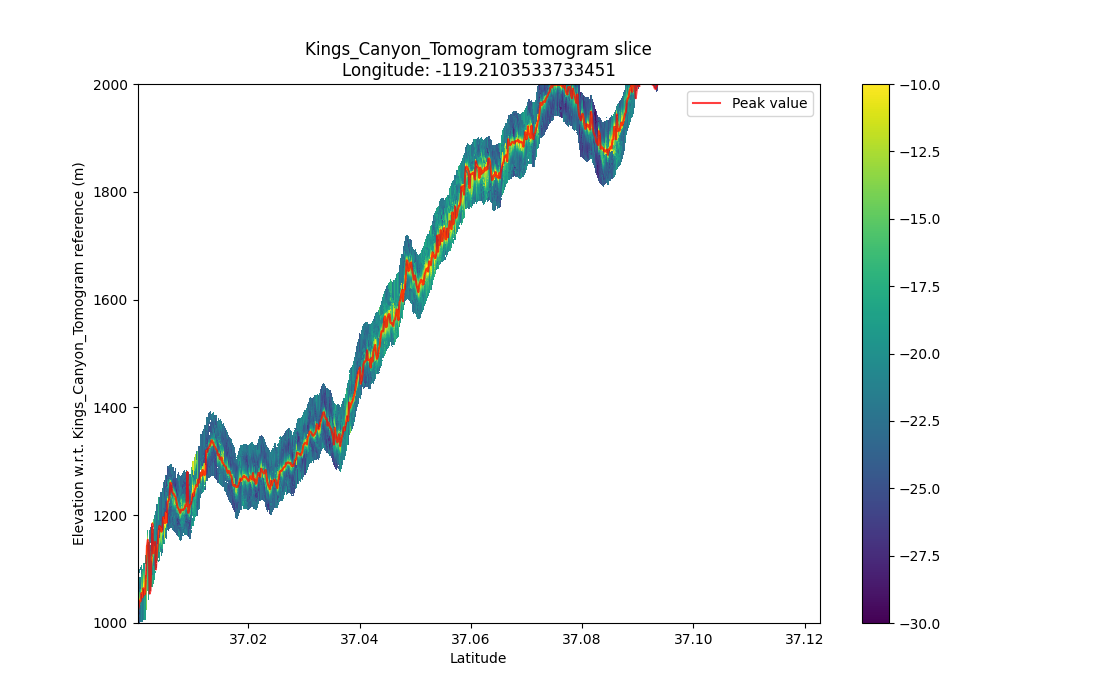

In [4]:
params = dict(
    ds=TOMOGRAM_DS_KC,
    output='PNG',
    longitude=-119.2103533733451,
    minLat=37,
    maxLat=37.25,
    minElevation=1000,
    maxElevation=2000,
    stride=1,
    peaks=True
)

response = get(TOMOGRAM_LON_URL, params)

buf = BytesIO(response.content)

img = Image.open(buf).convert('RGB')
display(img)

Waiting for response from SDAP... Done in 0:00:09.501243


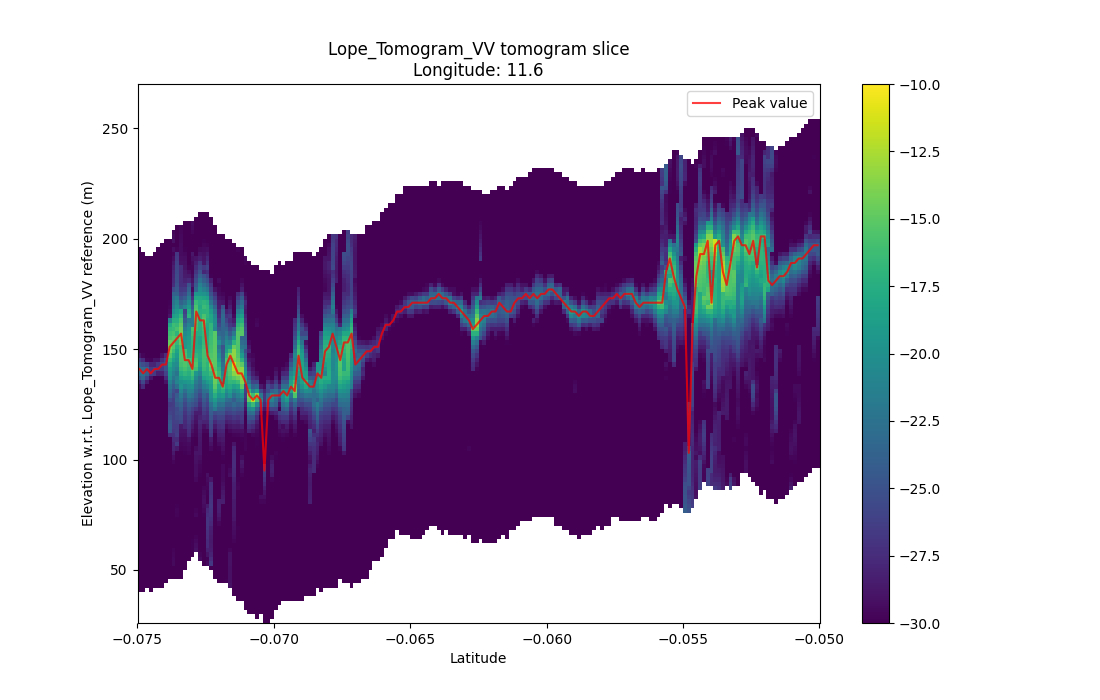

In [5]:
params = dict(
    ds=TOMOGRAM_DS_Lope.format('VV'),
    output='PNG',
    longitude=11.6,
    minLat=-0.075,
    maxLat=-0.05,
    minElevation=5,
    maxElevation=350,
    stride=2, elevationMargin=1,
    peaks=True
)

response = get(TOMOGRAM_LON_URL, params)

buf = BytesIO(response.content)

img = Image.open(buf).convert('RGB')
display(img)

Waiting for response from SDAP... Done in 0:00:36.799726


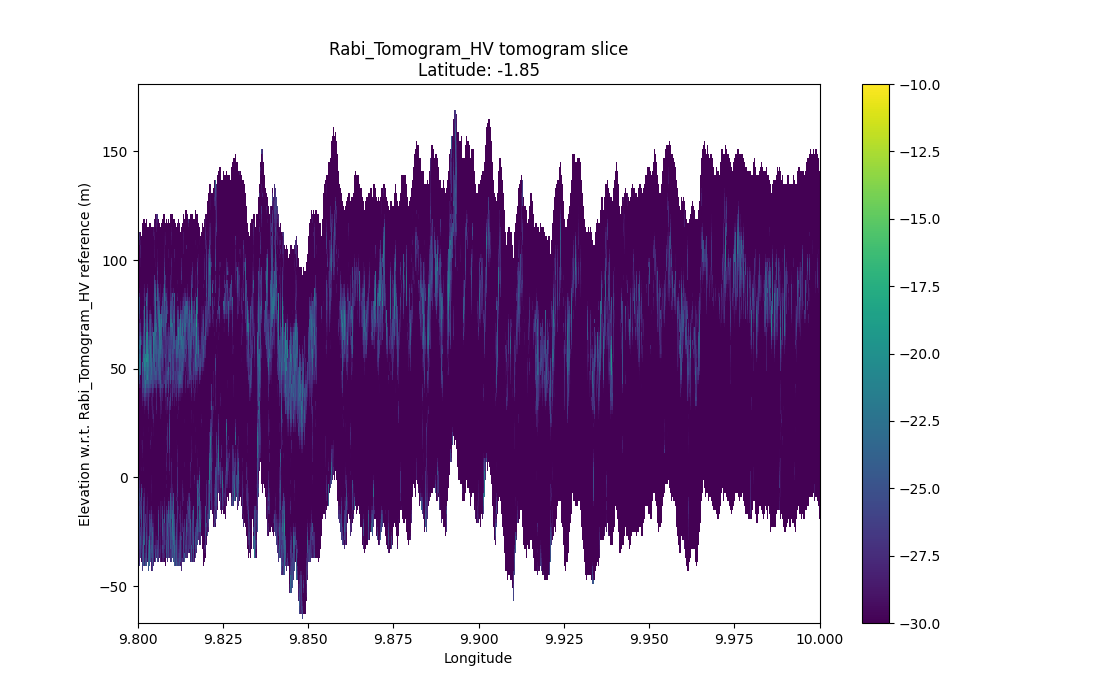

In [6]:
params = dict(
    ds=TOMOGRAM_DS_Rabi.format('HV'),
    output='PNG',
    latitude=-1.85,
    minLon=9.8,
    maxLon=10,
    minElevation=-90,
    maxElevation=1200,
    stride=2, elevationMargin=1,
    peaks=False
)

response = get(TOMOGRAM_LAT_URL, params)

buf = BytesIO(response.content)

img = Image.open(buf).convert('RGB')
display(img)

### Tomograms - 3D Plot Example

Waiting for response from SDAP... Done in 0:01:31.027909


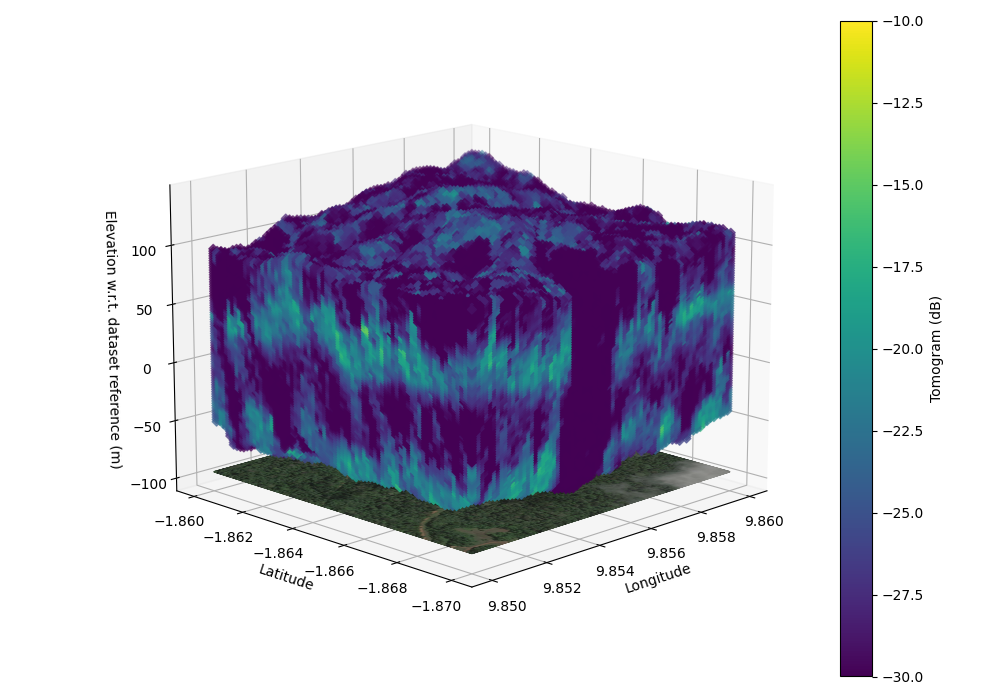

In [8]:
params = dict(
    ds=TOMOGRAM_DS_Rabi.format('VV'),
    output='PNG',
    b='9.85,-1.87,9.86,-1.86',
    minElevation=-95,
    maxElevation=240,
    viewAngle='225,15'
)

response = get(TOMOGRAM_3D_URL, params)

buf = BytesIO(response.content)

img = Image.open(buf).convert('RGB')
display(img)

### Tomograms - Other Output Formats

Tomograms subsets can be returned in a simple CSV format to be used with VR tools to enable users to interactively manipilate and explore the data.

In [9]:
params = dict(
    ds=TOMOGRAM_DS_Rabi.format('VV'),
    output='CSV',
    b='9.85,-1.87,9.86,-1.86',
    minElevation=-95,
    maxElevation=240
)

response = get(TOMOGRAM_3D_URL, params)

buf = StringIO(response.text)

df = pd.read_csv(buf, names=['x', 'y', 'z', 'value'])
df

Waiting for response from SDAP... Done in 0:01:07.793259


x         y           z      value
0       9.850069 -1.869931  100.511040 -29.246452
1       9.850486 -1.869931  104.491989 -28.281374
2       9.850625 -1.869931  105.052017 -29.514868
3       9.850764 -1.869931  104.678276 -24.330778
4       9.850903 -1.869931  103.569534 -25.520317
...          ...       ...         ...        ...
401307  9.858542 -1.860069  -32.272484 -18.552767
401308  9.859514 -1.860069  -25.494308 -24.895353
401309  9.859653 -1.860069  -24.173836 -25.453016
401310  9.859792 -1.860069  -23.166481 -22.734806
401311  9.859931 -1.860069  -22.414238 -25.241951

[401312 rows x 4 columns]

## Kauri output

In [10]:
def kauri(b):
    params = {
        'dataset' : 'Kauri_sample_output',
        'b' : b,
        'startTime' : '1970-01-01T00:00:00Z',  # Data didn't have associated time, so ingested with 0
        'endTime' : '1970-01-01T00:00:00Z',
        'output' : 'ZIP'
    }
    
    url = f'{NEXUS_URL}/cdmssubset'
    
    t = datetime.now()
        
    try:
        print('Waiting for response from SDAP...', end='')
        response = requests.get(url, params=params, verify=False)
        td = datetime.now() - t
        response.raise_for_status()
    
        print(f' Done in {td}')
    except:
        td = datetime.now() - t
        print(f' Failed in {td}')
        print(response.text)
        raise
        
    response = BytesIO(response.content)
    
    print('Unpacking results')
    
    with ZipFile(response) as zipfile:
        namelist = zipfile.namelist()
        csv_buf = StringIO(zipfile.read(namelist[0]).decode('utf-8'))
        csv_data = pd.read_csv(csv_buf)
        
    print('Getting coordinate arrays')
    lats = np.unique(csv_data['latitude'].values)
    lons = np.unique(csv_data['longitude'].values)
    times = np.unique(csv_data['time'].values)
    
    data_col = [c for c in csv_data.columns if c not in ['time', 'latitude', 'longitude']][0]
    
    print('Gridding the result')
    
    vals_3d = np.empty((len(times), len(lats), len(lons)), dtype='float32')
    data_dict = {}
    
    for t in csv_data.itertuples(index=False):
        key = (t.time, t.latitude, t.longitude)
        data_dict[key] = getattr(t, data_col)
    
    for i, t in enumerate(times):
        for j, lat in enumerate(lats):
            for k, lon in enumerate(lons):
                vals_3d[i, j, k] = data_dict.get((t, lat, lon), np.nan)
            
    
    plt.figure(figsize=(14,12))
    plt.pcolormesh(*np.meshgrid(lons, lats), vals_3d[0])
    plt.title('ML-Predicted RH098 - Rabi Forest - SAR/Lidar fusion')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    cb = plt.colorbar(label='Canopy height (98th percentile) [m]')
    plt.show()

Waiting for response from SDAP... Done in 0:01:11.806198
Unpacking results
Getting coordinate arrays
Gridding the result


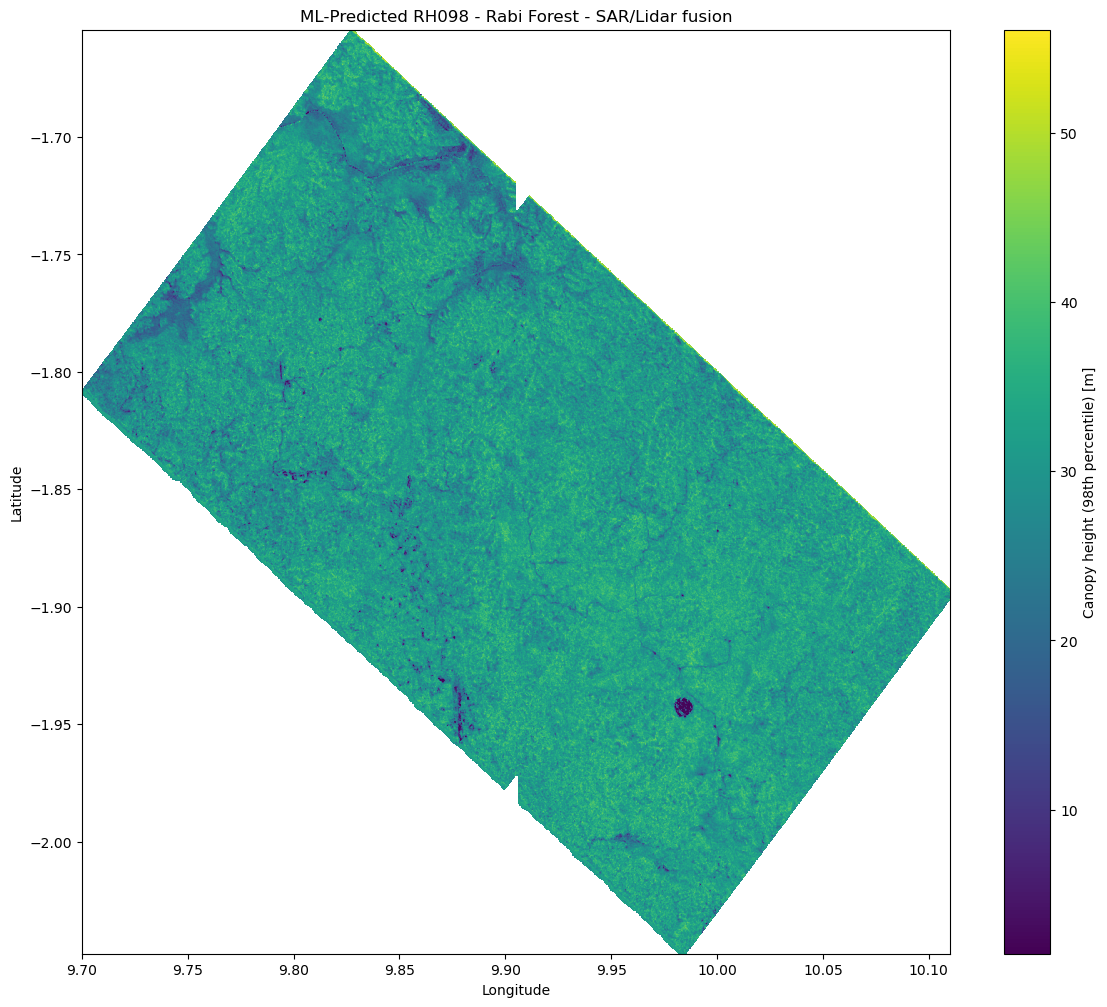

In [11]:
kauri('9.70,-2.05,10.11,-1.65')

Waiting for response from SDAP... Done in 0:00:09.544573
Unpacking results
Getting coordinate arrays
Gridding the result


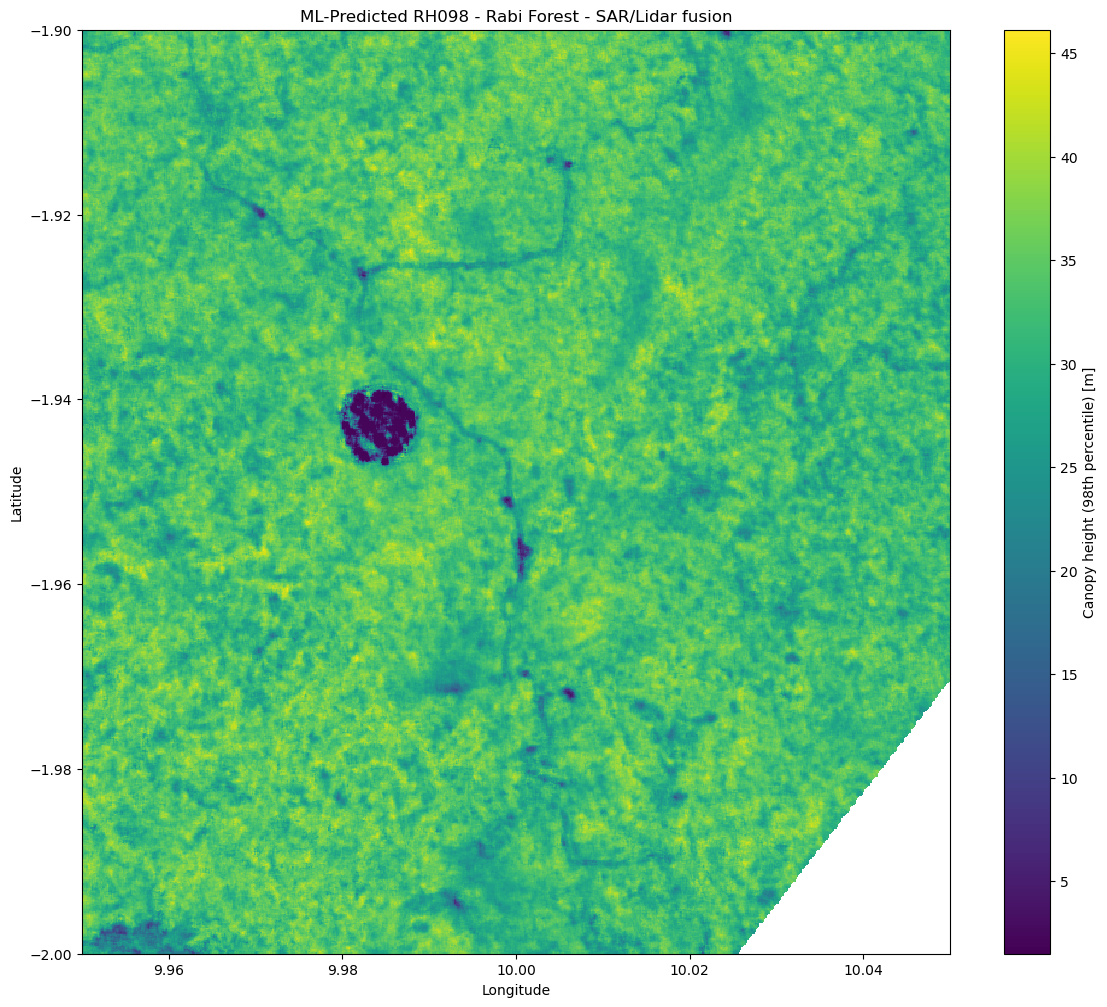

In [12]:
kauri('9.95,-2.0,10.05,-1.9')

## LIDAR

The following cells will showcase SDAP's LIDAR endpoint (Still a WIP)

### LIDAR - PNG Output

Waiting for response from SDAP... Done in 0:00:05.153181


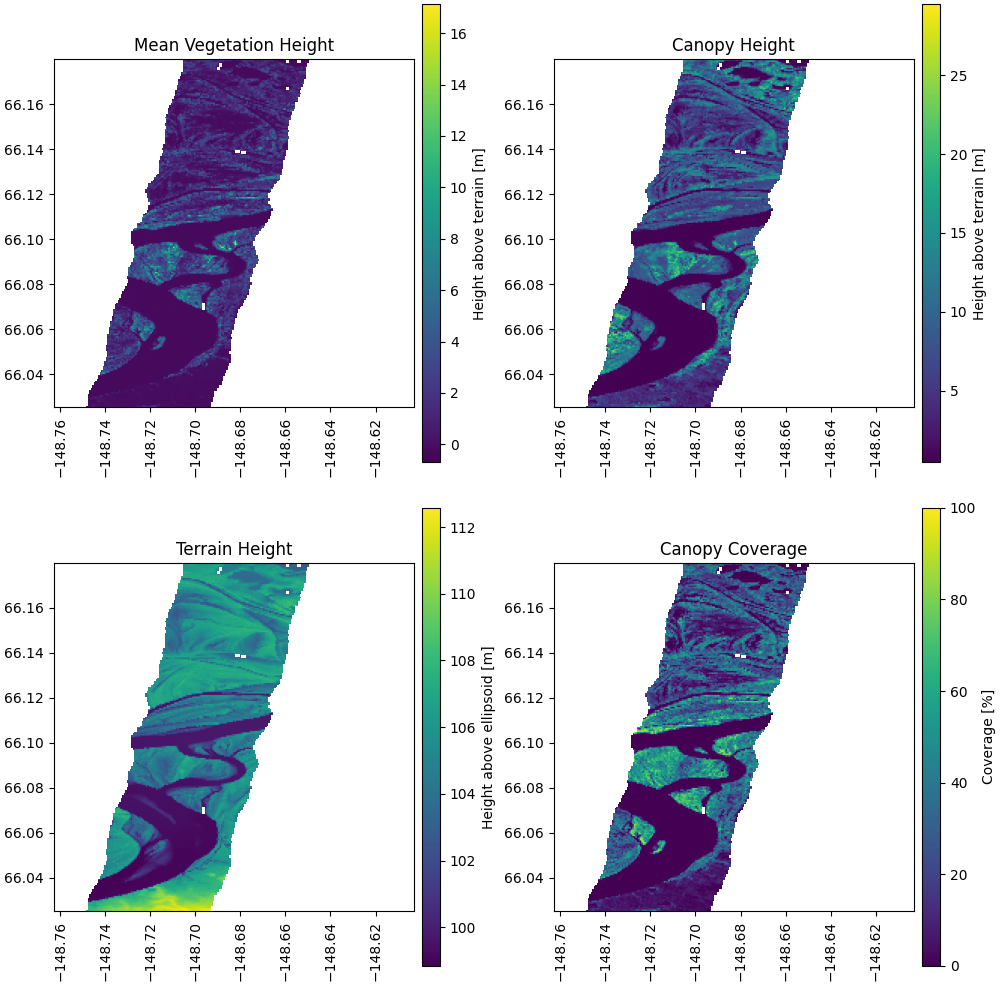

In [13]:
params = dict(
    ds=LIDAR_DS,
    b='-148.8,66.025,-148.5,66.18',
    startTime='2016-06-28T00:00:00Z',
    endTime='2020-06-30T00:00:00Z',
    output='PNG',
    mapToGrid=True
)

response = get(LIDAR_URL, params)
response.raise_for_status()
buf = BytesIO(response.content)

img = Image.open(buf).convert('RGB')
display(img)

### LIDAR - NetCDF Output & Profile Slicing

Profile slicing can be defined by longitude, latitude, or an arbitrary WKT LineString.

It is supported by all output formats except CSV, but showcased here for the NetCDF output format as the plotting in the PNG format is still an awkward work in progress.

In [14]:
params = dict(
    ds='LVIS_ABoVE',
    b='-122.3,46,-122,46.25',
    startTime='2016-06-28T00:00:00Z',
    endTime='2020-06-30T00:00:00Z',
    output='NetCDF',
    filename='lidar.nc',
    mapToGrid=True,
    sliceSamples=10000,
    sliceWKT='LINESTRING (-122.12 46.07, -122.09095182261792 46.0220916078604)',
    latSlice=46.09
)

response = get(LIDAR_URL, params)
response.raise_for_status()
buf = BytesIO(response.content)

ds = xr.open_dataset(buf).isel(time=0)
ds

Waiting for response from SDAP... Done in 0:01:28.013126


<xarray.Dataset>
Dimensions:                    (lat: 887, lon: 874, distance: 271)
Coordinates:
    time                       datetime64[ns] 2019-08-07
  * lat                        (lat) float64 46.0 46.0 46.0 ... 46.25 46.25
  * lon                        (lon) float64 -122.3 -122.3 ... -122.0 -122.0
  * distance                   (distance) float64 0.0 21.82 ... 7.531e+03
Data variables:
    ground_height              (lat, lon) float64 ...
    mean_veg_height            (lat, lon) float64 ...
    canopy_height              (lat, lon) float64 ...
    canopy_coverage            (lat, lon) float64 ...
    lat_slice_ground_height    (lon) float64 ...
    lat_slice_mean_veg_height  (lon) float64 ...
    lat_slice_canopy_height    (lon) float64 ...
    lat_slice_canopy_coverage  (lon) float64 ...
    slice_ground_height        (distance) float64 ...
    slice_mean_veg_height      (distance) float64 ...
    slice_canopy_height        (distance) float64 ...
    slice_canopy_coverage      (distance) float64 ...
Attributes:
    ground_height_dataset:           LVIS_ABoVE
    vegetation_mean_height_dataset:  LVIS_ABoVE
    canopy_height_dataset:           LVIS_ABoVE
    canopy_coverage_dataset:         LVIS_ABoVE
    start_time:                      2019-08-07T00:00:00
    end_time:                        2019-08-07T00:00:00
    b:                               -122.27716922973381,46.00001176648866,-1...
    slice_lat:                       [  46.09       -122.27716923 -122.03100691]
    slice_wkt:                       LINESTRING (-122.12 46.07, -122.09095182...
    slice_samples_requested:         10000
    slice_samples_actual:            271

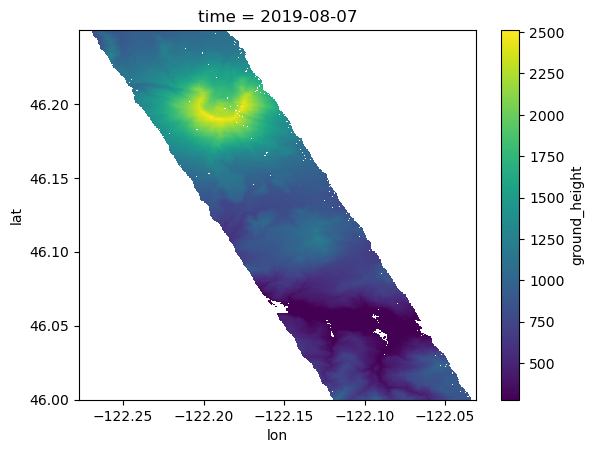

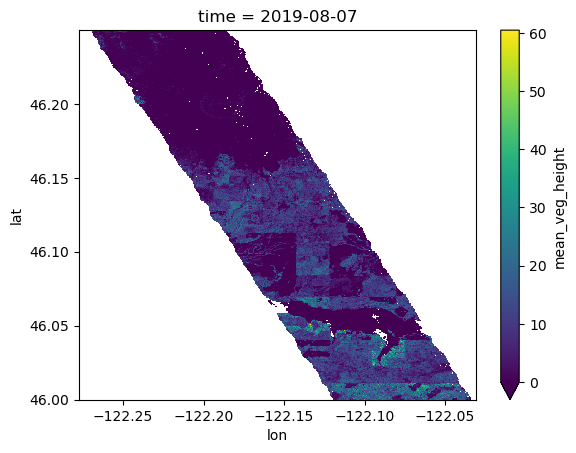

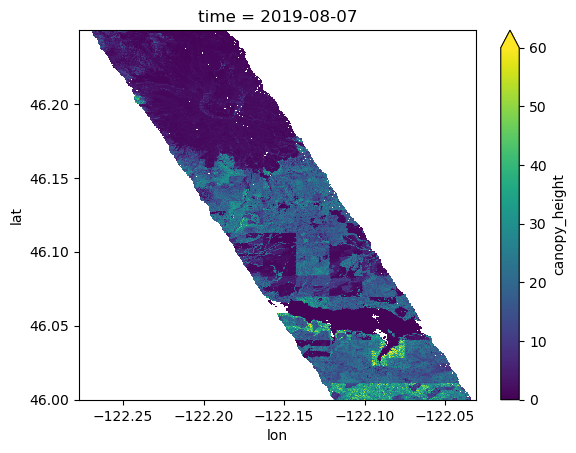

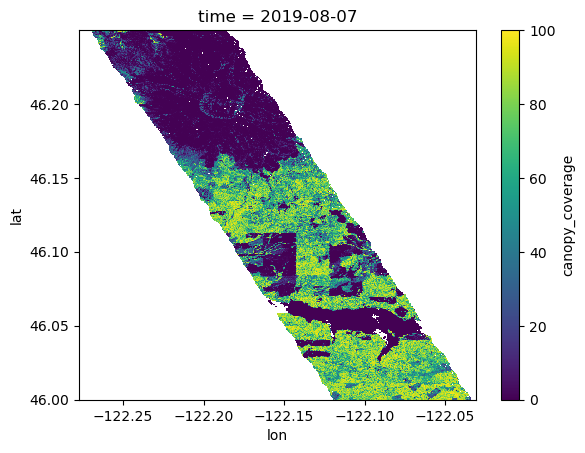

In [16]:
ds.ground_height.plot(cmap='viridis'); plt.show()
ds.mean_veg_height.plot(cmap='viridis', vmin=0); plt.show()
ds.canopy_height.plot(cmap='viridis', vmin=0, vmax=60); plt.show()
ds.canopy_coverage.plot(cmap='viridis', vmin=0, vmax=100); plt.show()

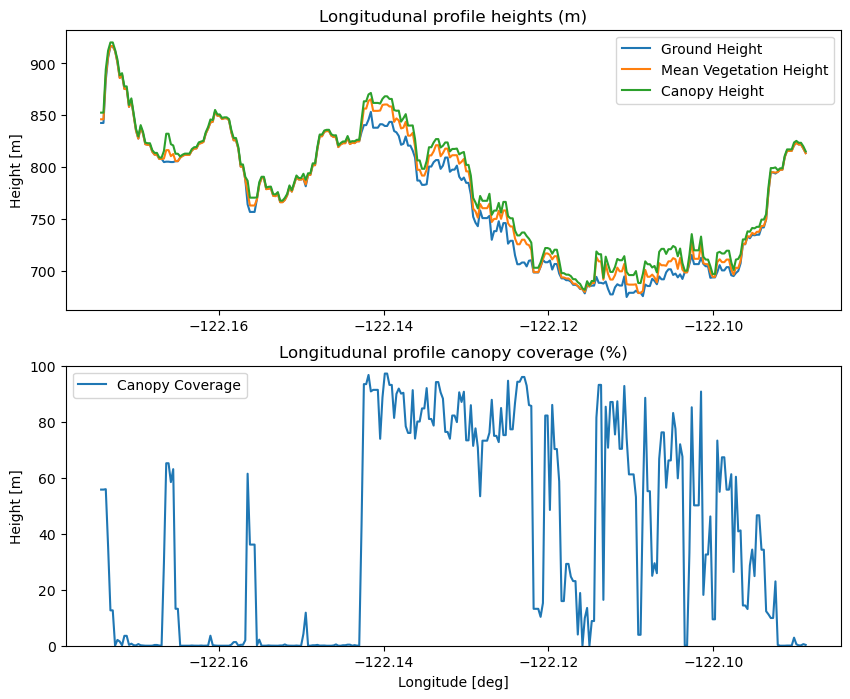

In [17]:
x_pts = ds.lon.to_numpy()
rh50_pts = ds['lat_slice_mean_veg_height'].to_numpy()
rh98_pts = ds['lat_slice_canopy_height'].to_numpy()
zg_pts = ds['lat_slice_ground_height'].to_numpy()
cc_pts = ds['lat_slice_canopy_coverage'].to_numpy()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 8))

ax1.plot(
    x_pts, zg_pts,
    x_pts, zg_pts + rh50_pts,
    x_pts, zg_pts + rh98_pts,
)
ax1.set_title('Longitudunal profile heights (m)')
ax1.legend([
    'Ground Height',
    'Mean Vegetation Height',
    'Canopy Height'
])
ax1.set_ylabel('Height [m]')

ax2.plot(x_pts, cc_pts)
ax2.set_title('Longitudunal profile canopy coverage (%)')
ax2.legend(['Canopy Coverage'])
ax2.set_ylim([0, 100])
ax2.set_xlabel('Longitude [deg]')
ax2.set_ylabel('Height [m]')

plt.show()

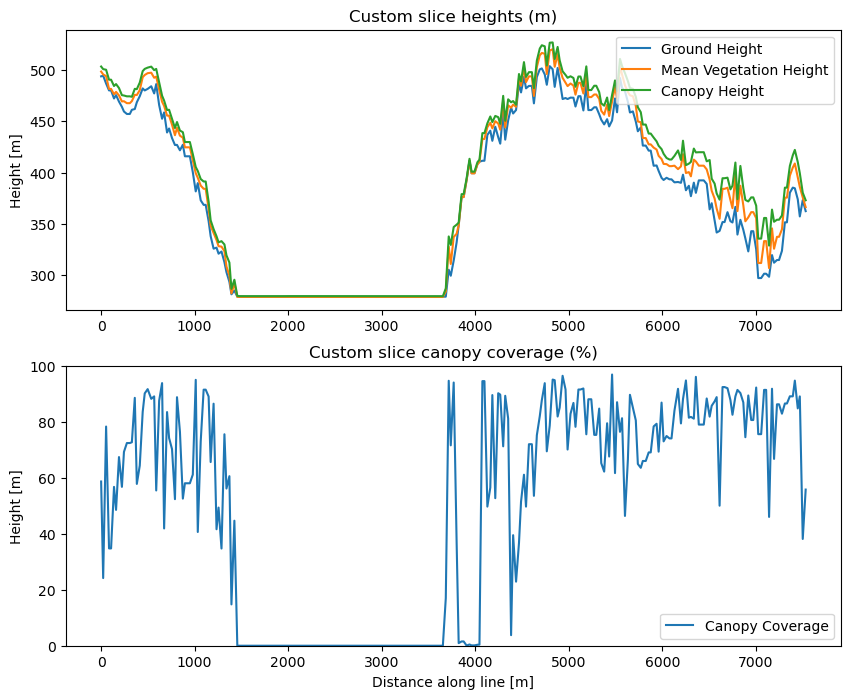

In [18]:
x_pts = ds.distance.to_numpy()
rh50_pts = ds['slice_mean_veg_height'].to_numpy()
rh98_pts = ds['slice_canopy_height'].to_numpy()
zg_pts = ds['slice_ground_height'].to_numpy()
cc_pts = ds['slice_canopy_coverage'].to_numpy()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 8))

ax1.plot(
    x_pts, zg_pts,
    x_pts, zg_pts + rh50_pts,
    x_pts, zg_pts + rh98_pts,
)
ax1.set_title('Custom slice heights (m)')
ax1.legend([
    'Ground Height',
    'Mean Vegetation Height',
    'Canopy Height'
])
ax1.set_ylabel('Height [m]')

ax2.plot(x_pts, cc_pts)
ax2.set_title('Custom slice canopy coverage (%)')
ax2.legend(['Canopy Coverage'])
ax2.set_ylim([0, 100])
ax2.set_ylabel('Height [m]')
ax2.set_xlabel('Distance along line [m]')

plt.show()

### LIDAR - CSV & ZIP Outputs

In [19]:
params = dict(
    ds='LVIS_ABoVE',
    b='-122.3,46,-122,46.25',
    startTime='2016-06-28T00:00:00Z',
    endTime='2020-06-30T00:00:00Z',
    output='CSV',
    filename='lidar.csv',
    mapToGrid=True,
)

response = get(LIDAR_URL, params)
response.raise_for_status()
buf = StringIO(response.text)

df = pd.read_csv(buf)
df

Waiting for response from SDAP... Done in 0:01:28.537392


latitude   longitude        time             time_iso  ground_height  \
0       46.000012 -122.119264  1565136000  2019-08-07T00:00:00     942.780029   
1       46.000012 -122.118700  1565136000  2019-08-07T00:00:00     990.434998   
2       46.000012 -122.118419  1565136000  2019-08-07T00:00:00     999.896667   
3       46.000012 -122.118137  1565136000  2019-08-07T00:00:00    1012.921692   
4       46.000012 -122.117855  1565136000  2019-08-07T00:00:00    1012.921692   
...           ...         ...         ...                  ...            ...   
268027  46.249840 -122.188066  1565136000  2019-08-07T00:00:00    1087.856689   
268028  46.249840 -122.187784  1565136000  2019-08-07T00:00:00    1087.510010   
268029  46.249840 -122.187502  1565136000  2019-08-07T00:00:00    1082.863770   
268030  46.249840 -122.187220  1565136000  2019-08-07T00:00:00    1082.863770   
268031  46.249840 -122.186938  1565136000  2019-08-07T00:00:00    1070.630005   

        mean_vegetation_height  canopy_height  canopy_coverage  
0                     1.080000      54.770000            36.78  
1                     8.547500      27.547501            74.13  
2                     3.534444       9.883333            44.39  
3                     0.895000       7.560000            23.61  
4                     0.895000       7.560000            23.61  
...                        ...            ...              ...  
268027               -0.225000       0.646667             0.00  
268028               -0.236667       0.711667             0.00  
268029               -0.218750       2.095000             0.77  
268030               -0.218750       2.095000             0.77  
268031               -0.170000       1.556667             0.06  

[268032 rows x 8 columns]

In [ ]:
params = dict(
    ds='LVIS_ABoVE',
    b='-122.3,46,-122,46.25',
    startTime='2016-06-28T00:00:00Z',
    endTime='2020-06-30T00:00:00Z',
    output='ZIP',
    filename='lidar.zip',
    mapToGrid=True,
    sliceSamples=10000,
    sliceWKT='LINESTRING (-122.12 46.07, -122.09095182261792 46.0220916078604)',
    latSlice=46.09
)

response = get(LIDAR_URL, params)
response.raise_for_status()
buf = BytesIO(response.content)

zipfile = ZipFile(buf)
zipfile.namelist()

In [ ]:
for csv in zipfile.namelist():
    print(f'{csv}:')
    csv_buf = StringIO(zipfile.read(csv).decode('utf-8'))
    csv_data = pd.read_csv(csv_buf)
    display(csv_data)